In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fftpack import fft, fftfreq
from functools import partial
import inspect
from scipy import signal
from scipy.signal import find_peaks
sys.path.append('../../')
from utils.utils import crop_dataframes, find_zero_crossing, sine_wave, bandpass_filter, bandpass_savgol_filter, amplitude_envelope, rms_envelope, calculate_periodogram, plot_periodogram, fit_linear_regression

# EMG Noise Analysis

This notebook contains the analysis for evaluating the EMG Noise.

## Analysis Procedure

We obtain the signal to noise ratio for each device by generating a sine wave resembling that which was passed through the device. Although there is some additional noise added by the electronic components of the circuit, we assume that this noise will be equal for both devices. Therefore the figures that are calculated from this analysis should not be taken as absolute, but rather treated as measurements relative to one another.

## Data

Data can be downloaded [here](https://osf.io/8sxh3/?view_only=991096283e9e4fd18546bfa8fe3b0b4b)

# Myo

In [ ]:
# load emg and log

fp = "data/"

myo_path = "myo/emg/emg.csv"
event_path = "event_log/event_log.csv"

myo_df = pd.read_csv(os.path.join(fp, myo_path))
event_df = pd.read_csv(os.path.join(fp, event_path))

start_time = event_df.loc[event_df["Event"] == "Start Measurement Period", "Event Time"].values[0]
end_time = event_df.loc[event_df["Event"] == "End Measurement Period", "Event Time"].values[0]

In [3]:
print(f"Length of recording: {(end_time-start_time)/60} Minutes")

Length of recording: 5.095229367415111 Minutes


In [4]:
# crop emg to start and end times

myo_df = crop_dataframes(myo_df, start_time, end_time)
myo_emg = myo_df["emg3"].to_numpy()

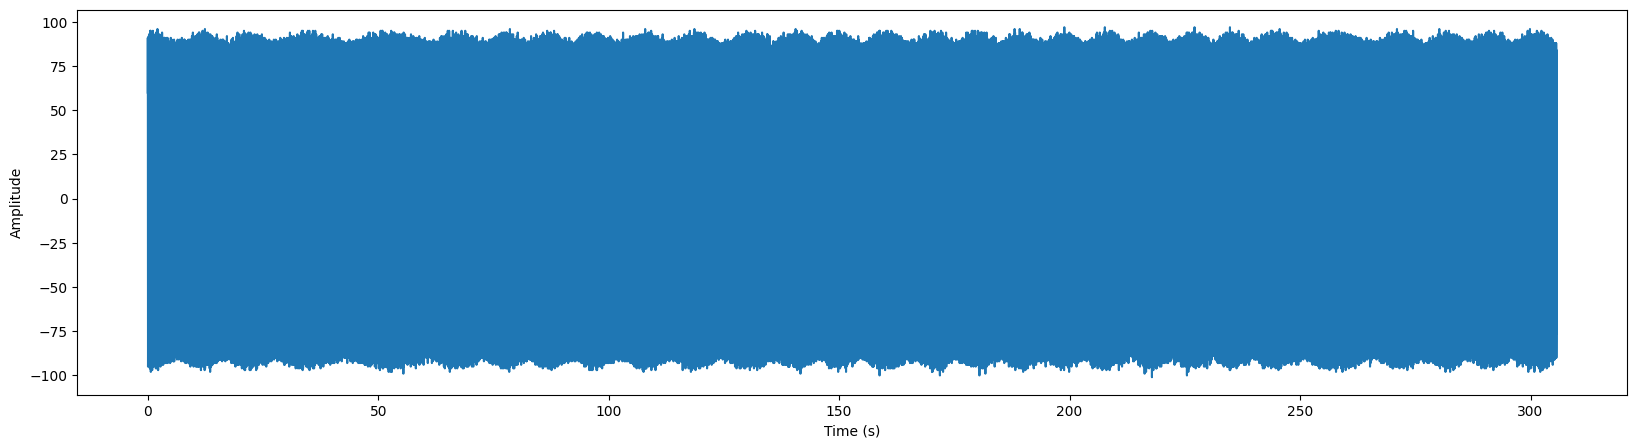

In [5]:
x = np.linspace(0, end_time-start_time, len(myo_df), endpoint=False)

plt.figure(figsize=(20, 5))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(x, myo_emg)
plt.show()

There is a visible amplitude modulation in the EMG signal. To remove this, we obtain the amplitude envelope using the Hilbert transform and scale the EMG signal by its envelope. This also has the added benefit of normalising the signal.

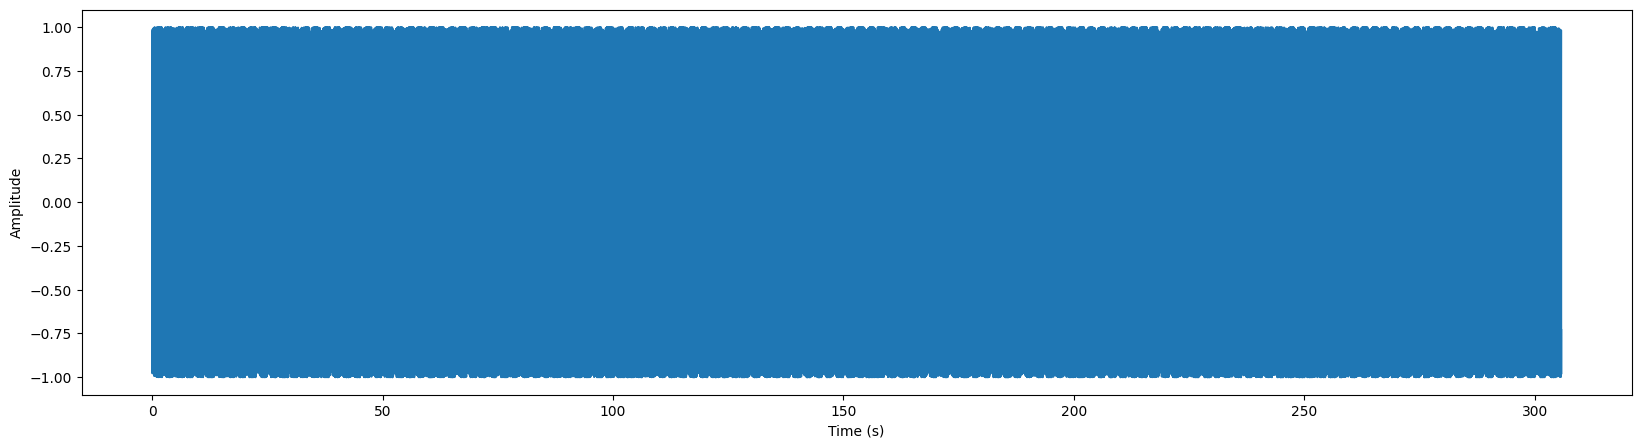

In [6]:
# calculate amplitude envelope and scale EMG signal with it

myo_env = amplitude_envelope(myo_emg)
myo_emg = myo_emg/myo_env

plt.figure(figsize=(20, 5))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(x, myo_emg)
plt.show()

We generate a reference signal with the same frequency as the sine wave passed through the device. As the EMG signal has been normalised, we simply set an amplitude of 1. We obtain the phase through visual inspection of the first second of the reference signal and the EMG signal.

In [7]:
# set reference signal phase - requires choosing a number and plotting in the next cell

reference_phase = 15

# generate signal

myo_sr = 200
t = np.arange(0, len(myo_emg))/myo_sr
a = 1
f = 10
reference = sine_wave(t, a, f, (reference_phase/myo_sr)*2*np.pi, 0)

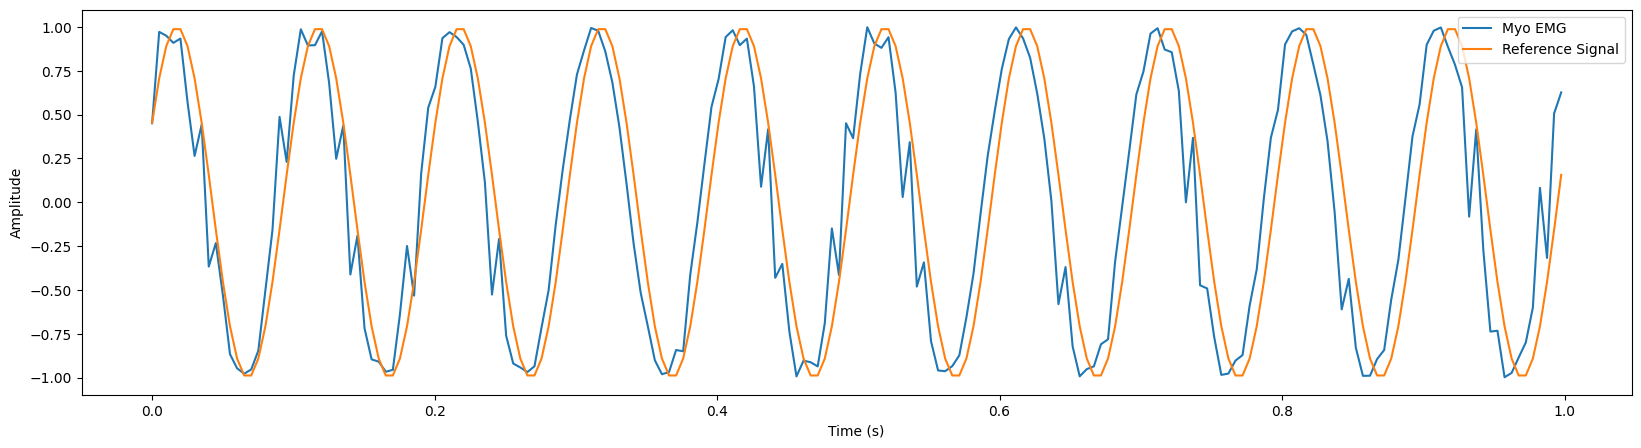

In [8]:
# plot first second to check phase alignment

plt.figure(figsize=(20, 5))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(x[:200], myo_emg[:200], label="Myo EMG")
plt.plot(x[:200], reference[:200], label="Reference Signal")
plt.legend()
plt.show()

Note, that the signals seem slightly out of alignment. Now we plot the noise component, taken as the absolute value of the EMG signal minus the reference signal.

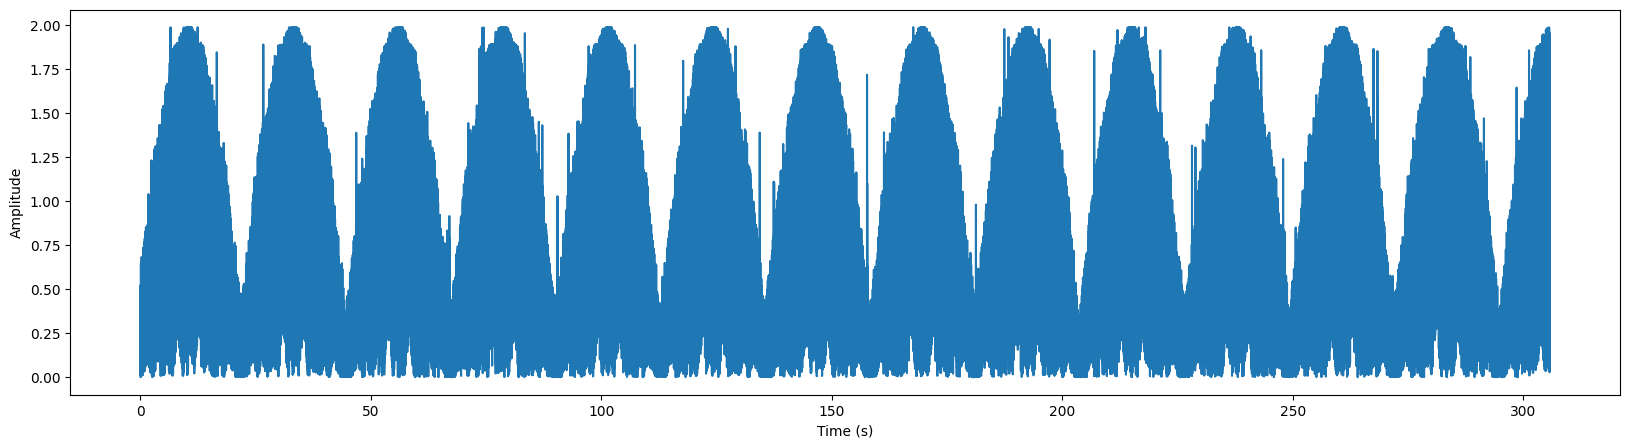

In [9]:
noise = np.abs(myo_emg-reference)
#noise = noise/np.max(noise)

plt.figure(figsize=(20, 5))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(x, noise)
plt.show()

Here the issue becomes very visible. The noise values indicate that the two signals are going completely out of phase at regular intervals. This indicates that the frequencies of the two signals are not identical, but are close together. This results in "beating". We can calculate the periodogram to show the frequency band in which most energy is present.

Highest spectral power density at 10.04542249479363 Hz


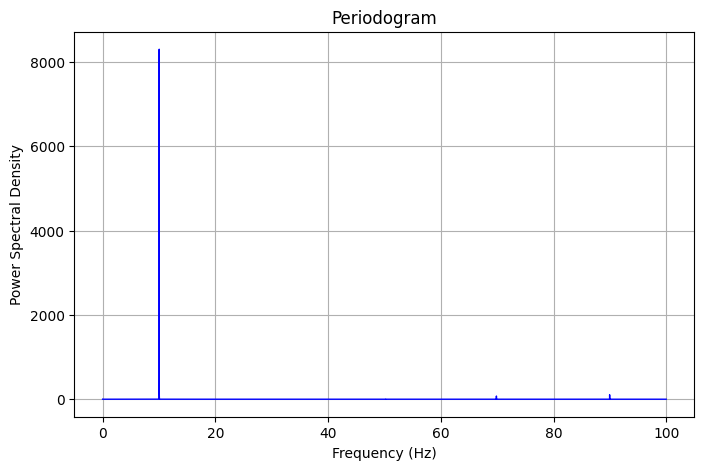

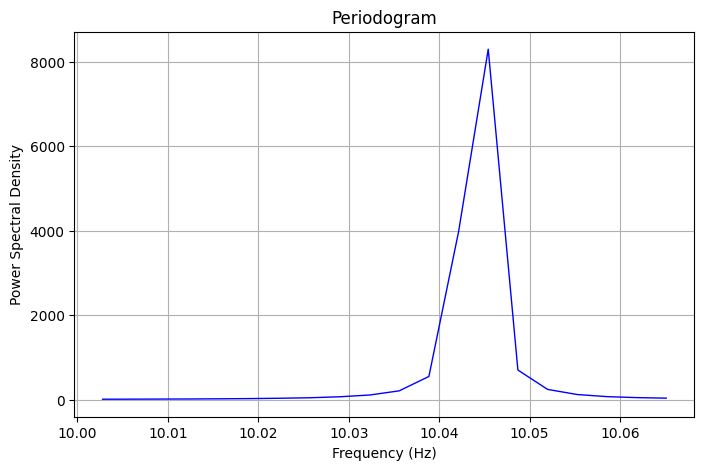

In [ ]:
# first plot whole and then zoomed in around 10Hz

myo_freqs, myo_psd = calculate_periodogram(myo_emg, myo_sr)
print(f"Highest spectral power density at {myo_max} Hz")
plot_periodogram(myo_freqs, myo_psd)
plot_periodogram(myo_freqs[3050:3070], myo_psd[3050:3070])

We can see that the peak in the spectral power density for the Myo signal is actually a little over 10Hz. This could indicate either that the Myo clock has some slight drift, or that the clock of the Bitscope Micro is slightly off. If this is the same for the SiFiBand, it indicates an imprecision in the Bitscope Micro. If not, this indicates clock drift in the Myo. This mismatch in frequency occured over multiple data collections.

In [ ]:
# Using the peak of the spectral power density actually still results in a small visible low frequency offset. This is perhaps due to the frequency banding of the periodogram calculation.
# The value here results in the flattest noise plot (i.e. with no offset)
f = 10.04408103
reference = sine_wave(t, a, f, (reference_phase/myo_sr)*2*np.pi, 0)

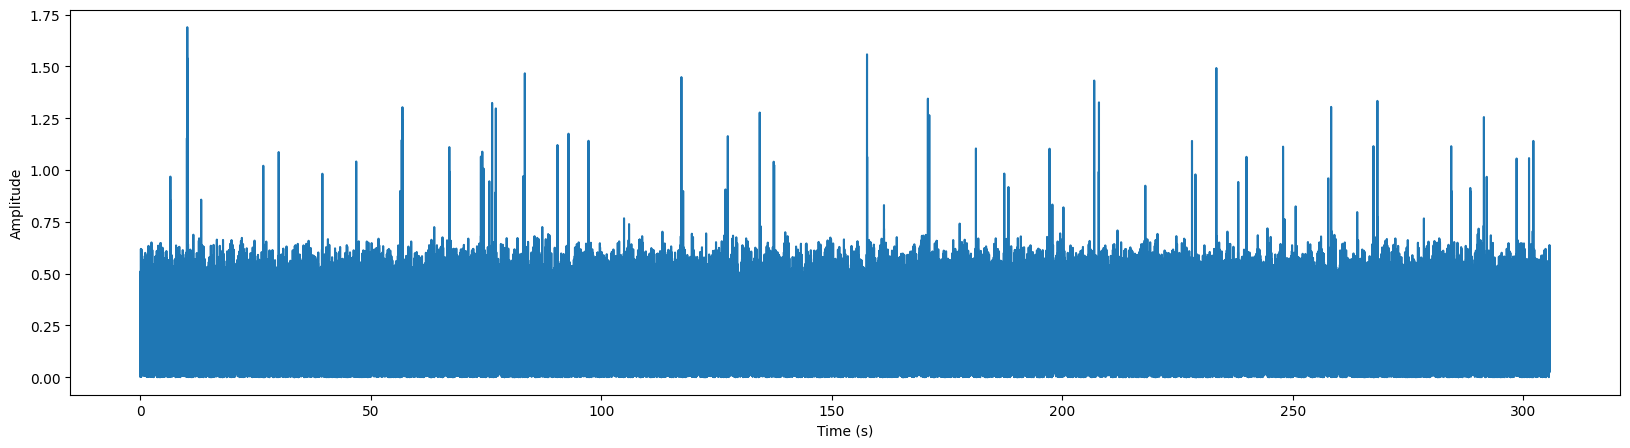

Mean of Myo Noise 0.17230974826467169
Standard Deviation of Myo Noise 0.1488254779938489


In [12]:
noise = np.abs(myo_emg-reference)
#noise = noise/np.max(noise)

plt.figure(figsize=(20, 5))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(x, noise)
plt.show()

print(f"Mean of Myo Noise {np.mean(noise)}")
print(f"Standard Deviation of Myo Noise {np.std(noise)}")

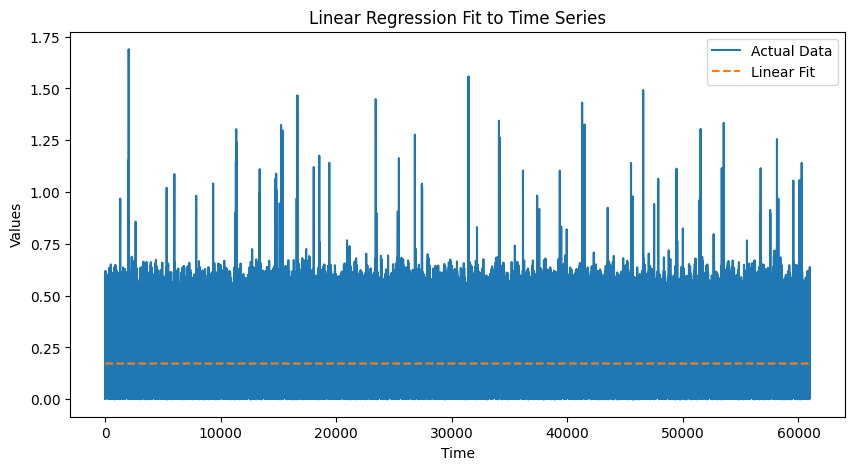

Slope of Linear Regression: 0.00000000


In [13]:
lin_reg = fit_linear_regression(noise)
print(f"Slope of Linear Regression: {lin_reg['slope']:.8f}")

Now we can calculate the Signal to Noise ratio.

In [14]:
var_ref = np.var(reference)
var_noise = np.var(noise)
myo_snr = 10*np.log10(var_ref/var_noise)

print(f"Signal to Noise Ratio for Myo: {myo_snr} dB")

Signal to Noise Ratio for Myo: 13.536109106245407 dB


## SiFi

In [15]:
fp = "../../data_collection/logs/2025_02_25_16_58_53_SiFi_EMG_Noise/"

sifi_path = "sifiband/emg/emg.csv"
event_path = "event_log/event_log.csv"

sifi_df = pd.read_csv(os.path.join(fp, sifi_path))
event_df = pd.read_csv(os.path.join(fp, event_path))

start_time = event_df.loc[event_df["Event"] == "Start Measurement Period", "Event Time"].values[0]
end_time = event_df.loc[event_df["Event"] == "End Measurement Period", "Event Time"].values[0]

In [16]:
print(f"Length of recording: {(end_time-start_time)/60} Minutes")

Length of recording: 5.076431814829508 Minutes


In [17]:
# crop emg to start and end times, and zero mean

sifi_df = crop_dataframes(sifi_df, start_time, end_time)
sifi_emg = sifi_df["emg0"].to_numpy()
sifi_emg = sifi_emg-np.mean(sifi_emg)

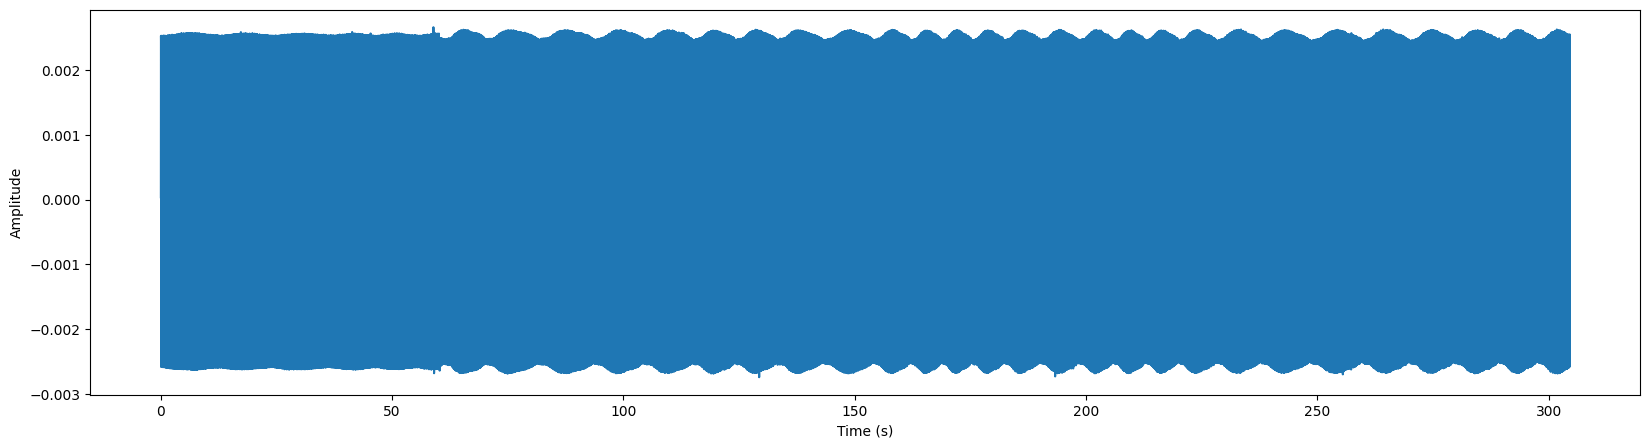

In [18]:
x = np.linspace(0, end_time-start_time, len(sifi_df), endpoint=False)

plt.figure(figsize=(20, 5))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(x, sifi_emg)
plt.show()

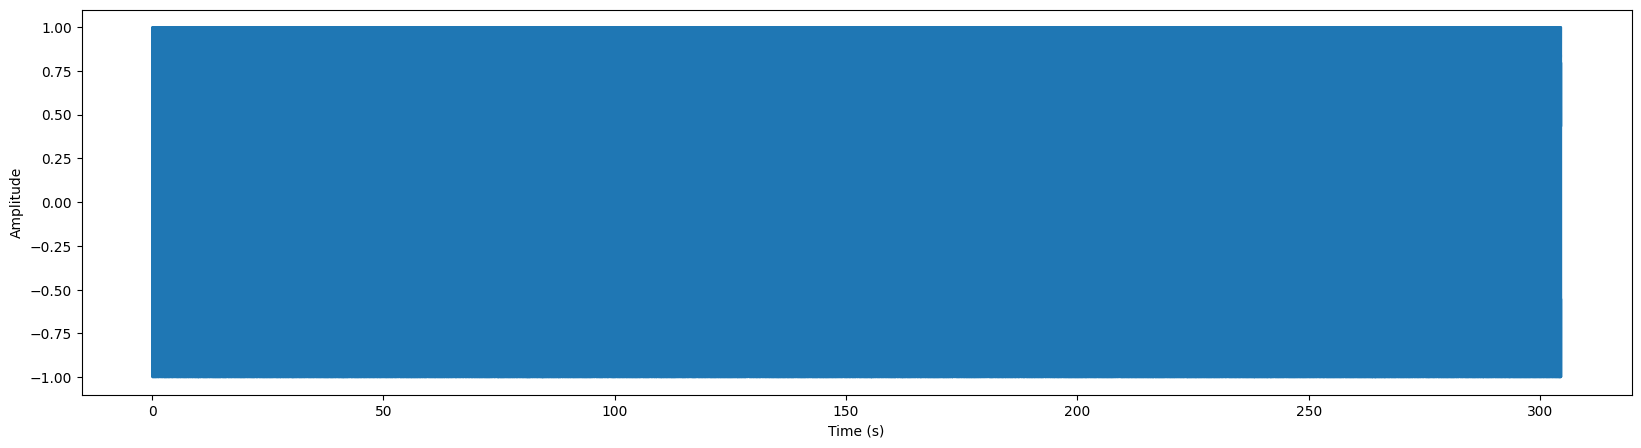

In [19]:
# calculate amplitude envelope and scale EMG signal with it

sifi_env = amplitude_envelope(sifi_emg)
sifi_emg = sifi_emg/sifi_env

plt.figure(figsize=(20, 5))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(x, sifi_emg)
plt.show()

In [20]:
# set reference signal phase - requires choosing a number and plotting in the next cell

reference_phase = 0

# generate signal

sifi_sr = 2000
t = np.arange(0, len(sifi_emg))/sifi_sr
a = 1
f = 10
reference = sine_wave(t, a, f, (reference_phase/sifi_sr)*2*np.pi, 0)

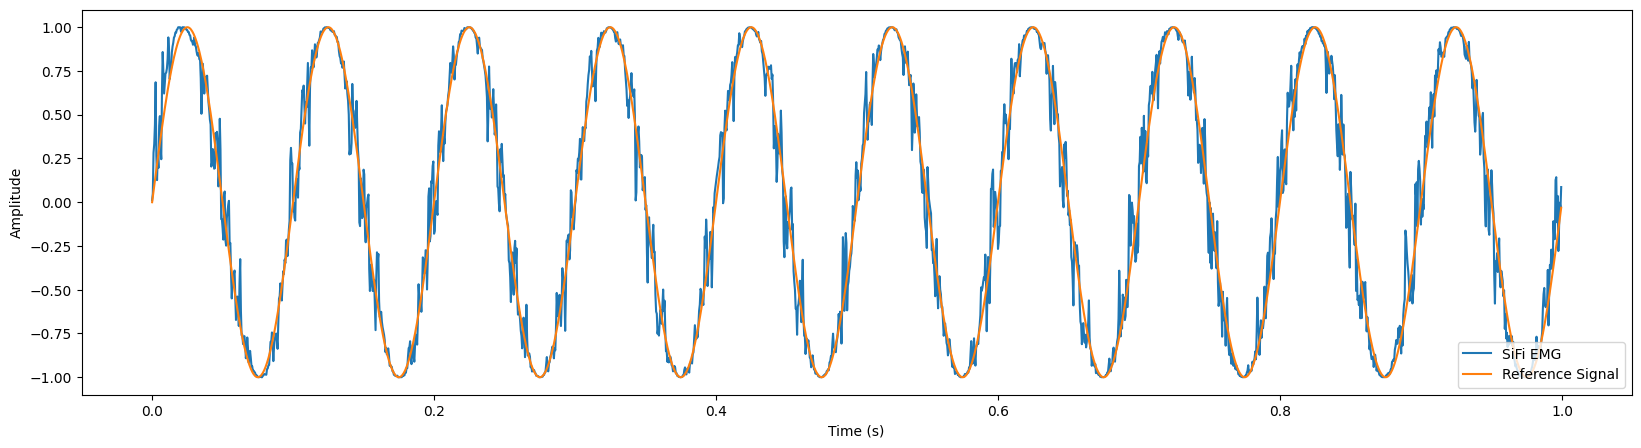

In [21]:
# plot first second to check phase alignment

plt.figure(figsize=(20, 5))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(x[:2000], sifi_emg[:2000], label="SiFi EMG")
plt.plot(x[:2000], reference[:2000], label="Reference Signal")
plt.legend(loc="lower right")
plt.show()

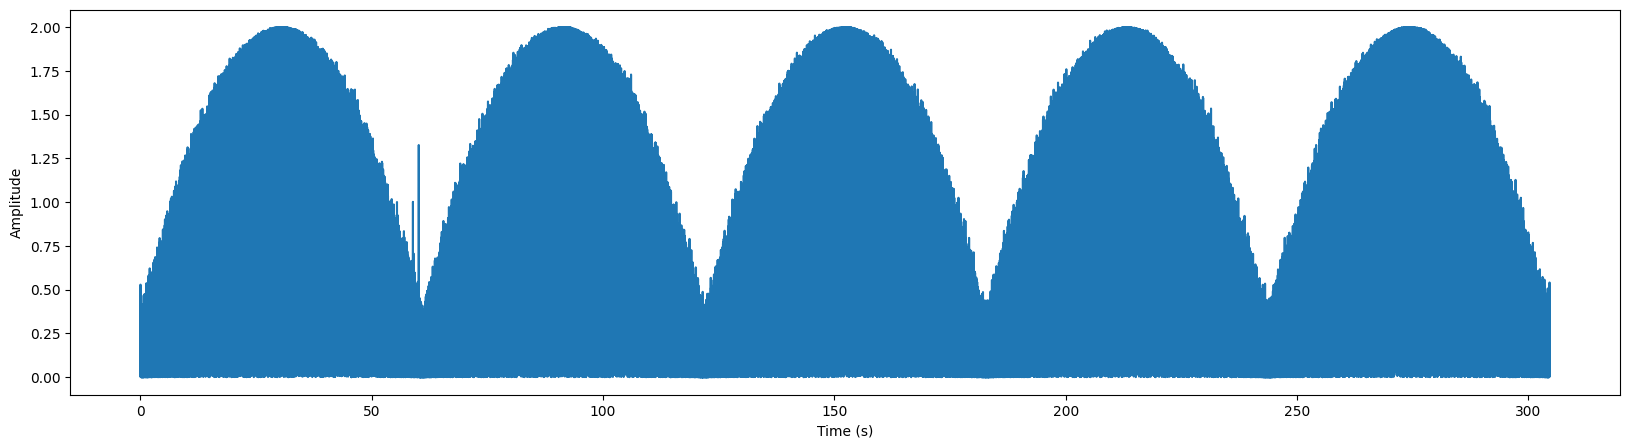

In [22]:
noise = np.abs(sifi_emg-reference)
#noise = noise/np.max(noise)

plt.figure(figsize=(20, 5))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(x, noise)
plt.show()

Highest spectral power density at 10.01760959222224 Hz


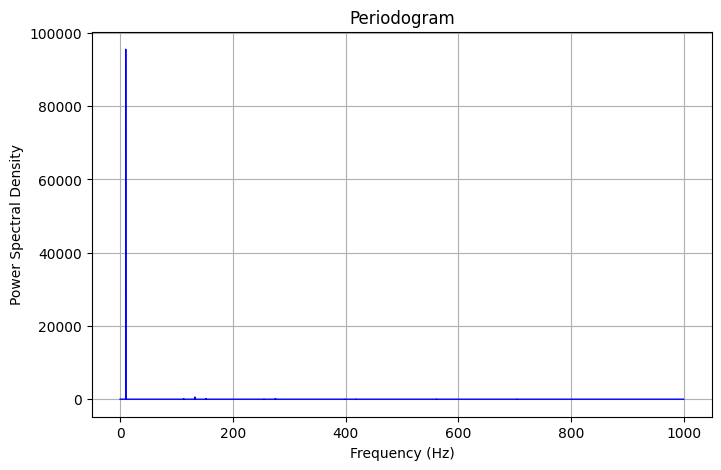

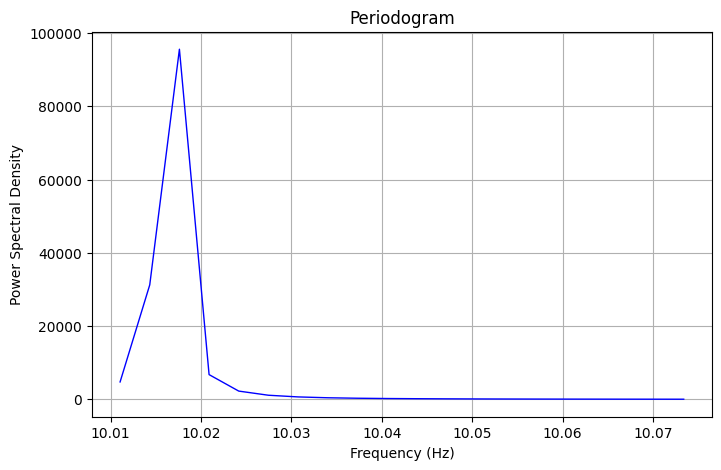

In [23]:
# first plot whole and then zoomed in around 10Hz

sifi_freqs, sifi_psd = calculate_periodogram(sifi_emg, sifi_sr)
sifi_max = sifi_freqs[np.argmax(sifi_psd)]
print(f"Highest spectral power density at {sifi_max} Hz")
plot_periodogram(sifi_freqs, sifi_psd)
plot_periodogram(sifi_freqs[3050:3070], sifi_psd[3050:3070])

In [ ]:
# Using the peak of the spectral power density actually still results in a small visible low frequency offset. This is perhaps due to the frequency banding of the periodogram calculation.
# The value here results in the flattest noise plot (i.e. with no offset)
f = 10.0164118
sifi_reference = sine_wave(t, a, f, (reference_phase/sifi_sr)*2*np.pi, 0)

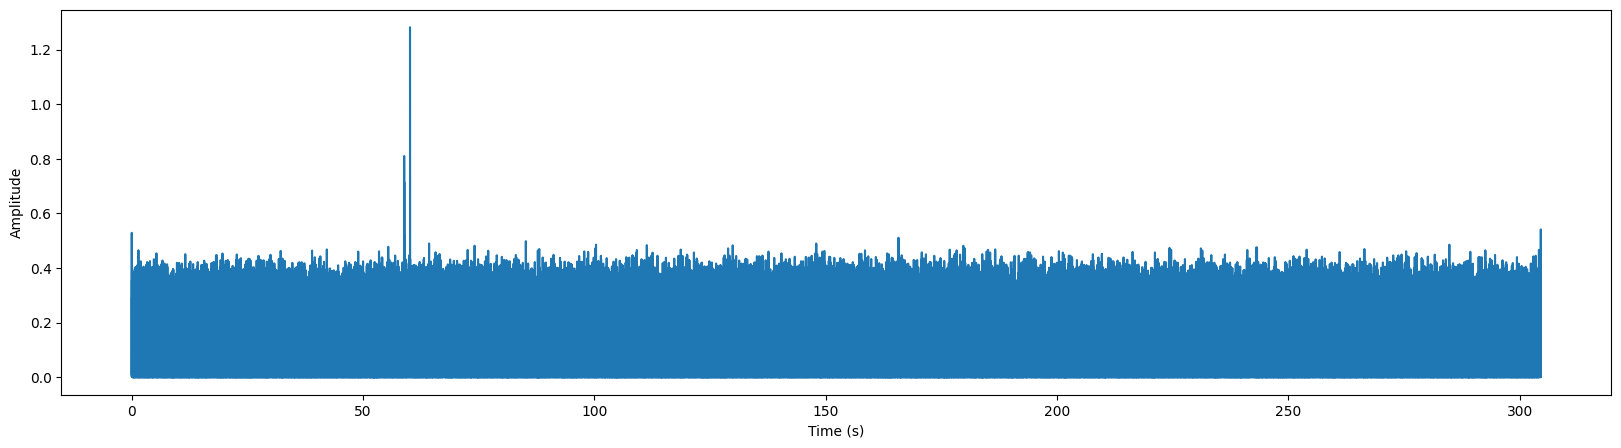

Mean of SiFi Noise 0.07297956632822836
Standard Deviation of SiFi Noise 0.08322594673510618


In [ ]:
sifi_noise = np.abs(sifi_emg-sifi_reference)
#noise = noise/np.max(noise)

plt.figure(figsize=(20, 5))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(x, noise)
plt.show()

print(f"Mean of SiFi Noise {np.mean(sifi_noise)}")
print(f"Standard Deviation of SiFi Noise {np.std(sifi_noise)}")

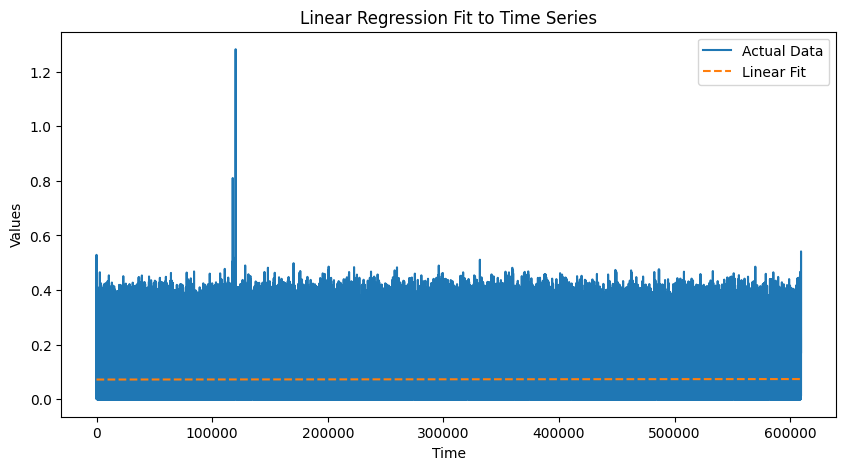

Slope of Linear Regression: 0.00000000


In [ ]:
lin_reg = fit_linear_regression(sifi_noise)
print(f"Slope of Linear Regression: {lin_reg['slope']:.8f}")

In [ ]:
var_ref = np.var(sifi_reference)
var_noise = np.var(sifi_noise)
sifi_snr = 10*np.log10(var_ref/var_noise)

print(f"Signal to Noise Ratio for SiFi: {sifi_snr} dB")

Signal to Noise Ratio for SiFi: 18.584408771467565 dB


In [ ]:
print(f"Difference in Signal to Noise Ratio: {np.abs(sifi_snr-myo_snr)} dB")

Difference in Signal to Noise Ratio: 5.048299665222158 dB
